In [1]:
import time
import hydra
from hydra.utils import to_absolute_path
import torch
import sys
import os
import torch.nn as nn

import argparse

from dgl.dataloading import GraphDataLoader
import dgl
from omegaconf import DictConfig

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel

#project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', ''))
#sys.path.append(project_path)
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from python.create_dgl_dataset import TelemacDataset
from modulus.distributed.manager import DistributedManager
from modulus.launch.logging import (
    PythonLogger,
    RankZeroLoggingWrapper,
    initialize_wandb,
)
from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMeshGraphNet import MeshGraphNet


In [2]:
from hydra.utils import to_absolute_path

In [3]:
import numpy as np

In [4]:
def collate_fn(batch):
    # batch is a list of sequences
    # Each sequence is a list of graphs (of length sequence_length)
    # We want to batch the graphs at each time step across sequences

    sequence_length = len(batch[0])  # Assuming all sequences have the same length

    batched_graphs = []
    for t in range(sequence_length):
        graphs_at_t = [sequence[t] for sequence in batch]
        batched_graph = dgl.batch(graphs_at_t)
        batched_graphs.append(batched_graph)

    return batched_graphs

class TestRollout:
    def __init__(self, cfg: DictConfig, logger: PythonLogger):
        self.sequence_length = cfg.sequence_length  # Use sequence_length from config
        self.overlap = cfg.overlap 
        # Set device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"Using {self.device} device")
        
        # Instantiate dataset
        self.dataset = TelemacDataset(
            name="telemac_test",
            data_dir=to_absolute_path(cfg.data_dir),
            dynamic_data_files=[to_absolute_path(path) for path in cfg.dynamic_dir],
            split="test",
            ckpt_path=cfg.ckpt_path,
            normalize=True,
            sequence_length=self.sequence_length,
            overlap=self.sequence_length
        )
        # Instantiate dataloader
        self.dataloader = GraphDataLoader(
            self.dataset,
            batch_size=1,  
            shuffle=False,
            drop_last=False,
            collate_fn=collate_fn,  # Use custom collate_fn if defined
        )
        print(f"DataLoader Length: {len(self.dataloader)}")

        # Instantiate the model
        self.model = MeshGraphNet(
            cfg.num_input_features,
            cfg.num_edge_features,
            cfg.num_output_features,
            processor_size=cfg.mp_layers,
            hidden_dim_processor=64,
            hidden_dim_node_encoder=64,
            hidden_dim_edge_encoder=64,
            hidden_dim_node_decoder=64,
            do_concat_trick=cfg.do_concat_trick,
            num_processor_checkpoint_segments=cfg.num_processor_checkpoint_segments,
        )
        if cfg.jit:
            self.model = torch.jit.script(self.model).to(self.device)
        else:
            self.model = self.model.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Load checkpoint
        load_checkpoint(
            to_absolute_path(cfg.ckpt_path),
            models=self.model,
            device=self.device,
            epoch=500
        )
        self.model = self.model.to(self.device)
        
        # Get the stats needed to denormalize and normalize
        node_stats = self.dataset.node_stats
        self.h_u_v_i_0_mean = np.array([
            node_stats['h'].item(),
            node_stats['u'].item(),
            node_stats['v'].item()
        ])
        self.h_u_v_i_0_std = np.array([
            node_stats['h_std'].item(),
            node_stats['u_std'].item(),
            node_stats['v_std'].item()
        ])

        self.delta_h_u_v_i_diff_mean = np.array([
            node_stats['delta_h'].item(),
            node_stats['delta_u'].item(),
            node_stats['delta_v'].item()
        ])
        self.delta_h_u_v_i_diff_std = np.array([
            node_stats['delta_h_std'].item(),
            node_stats['delta_u_std'].item(),
            node_stats['delta_v_std'].item()
        ])
        
        # Define feature indices
        self.dynamic_feature_start = 6  # Adjust based on your actual feature indices
        self.dynamic_feature_end = 9  # Adjust based on your actual feature indices
        
    def predict(self, graph):
        """
        Predicts the next time step given the input graph.
        Denormalizes input features and predictions.
        Returns the denormalized predicted values.
        """
        with torch.no_grad():
            pred = self.model(
                graph.ndata['x'].to(self.device),
                graph.edata['x'].to(self.device),
                graph.to(self.device)
            ).cpu().numpy()
        
        # Denormalize data
        h_u_v_i_0 = self._denormalize_data(
            graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
            self.h_u_v_i_0_mean,
            self.h_u_v_i_0_std
        )

        # Compute predicted h, u, v at next time step
        h_u_v_i_1_pred = self._denormalize_data(
            pred,
            self.delta_h_u_v_i_diff_mean,
            self.delta_h_u_v_i_diff_std
        ) + h_u_v_i_0
                
        return h_u_v_i_1_pred, h_u_v_i_0
        
    def maj_mask(self, pred, next_step):
        """
        Updates predictions by applying boundary conditions from the next step.
        pred and next_step are normalized.
        """
        next_step_np = next_step.numpy()
        # Identify nodes with specific boundary conditions
        self.q_mask = (next_step_np[:, 0:4] == [0, 0, 1, 0]).all(axis=1)
        self.h_mask = (next_step_np[:, 0:4] == [0, 1, 0, 0]).all(axis=1)
        result = np.empty_like(next_step_np)
        
        # Copy static features from next_step
        result[:, 0:6] = next_step_np[:, 0:6]
        
        # Use predictions for dynamic features
        result[:, 6:9] = pred
        
        # Apply boundary conditions
        result[self.q_mask, 6:9] = next_step_np[self.q_mask, 6:9]
        result[self.h_mask, 6:7] = next_step_np[self.h_mask, 6:7]
        return result 
    
    def predict_unroll(self, unroll_steps=1):
        predict = []
        groundtruth = []
        origin = []
        count=0
        for sequence in self.dataloader:
            print(count)
            count+=1
            # sequence is now a list of graphs
            sequence_length = len(sequence)
            if sequence_length < unroll_steps + 1:
                continue  # Skip sequences that are too short

            graph = sequence[0].clone()  # Start from the first graph in the sequence
            h_u_v_i_0 = None  # To store initial input at time t=0
            for i in range(unroll_steps):
                next_graph = sequence[i + 1]
                h_u_v_i_1_pred, h_u_v_i_0 = self.predict(graph)

                if i == 0:
                    origin.append(h_u_v_i_0)

                #noise_filter = h_u_v_i_1_pred[:, 0] < 5e-3
                #h_u_v_i_1_pred[noise_filter, :] = 0.0

                # Normalize the prediction to transfer to the next graph
                h_u_v_i_1_pred_norm = self._normalize_data(
                    h_u_v_i_1_pred,
                    self.h_u_v_i_0_mean,
                    self.h_u_v_i_0_std
                )

                # Apply boundary conditions
                next_step_result = self.maj_mask(
                    h_u_v_i_1_pred_norm,
                    next_graph.ndata['x']
                )

                # Update the graph's node features for the next prediction
                graph.ndata['x'] = torch.tensor(next_step_result, dtype=torch.float32)

            predict.append(h_u_v_i_1_pred)
            # Denormalize ground truth from next_graph
            groundtruth.append(self._denormalize_data(
                next_graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
                self.h_u_v_i_0_mean,
                self.h_u_v_i_0_std
            ))

        return predict, groundtruth, origin

    def _denormalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return tensor * std + mean 
    
    def _normalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return (tensor - mean) / std
    
    def get_raw_data(self, idx):
        self.pred_i = [var[:, idx] for var in self.pred]
        self.exact_i = [var[:, idx] for var in self.exact]
        return self.graphs, self.faces, self.pred_i, self.exact_i



In [5]:
import hydra
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf

import time 

# Initialize Hydra and set the configuration directory
with initialize(config_path="../bin/conf"):
    logger = PythonLogger("main")  # General python logger
    logger.file_logging()
    # Compose the configuration using the config name
    cfg = compose(config_name="Config1Group3Test")
    
    # Now call the training function with the composed config
    test = TestRollout(cfg,logger)
    
    predict,groundtruth,origin = test.predict_unroll(unroll_steps=12)
    

/tmp/ipykernel_2321583/2702168147.py:8: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../bin/conf"):
[17:45:12 - main - INFO] Using cuda device


Loading normalization statistics...


[17:45:34 - checkpoint - INFO] Loaded model state dictionary /work/m24046/m24046mrcr/new_tests_Group3/config1/MeshGraphNet.0.500.mdlus to device cuda


DataLoader Length: 204


[17:45:34 - checkpoint - INFO] Loaded checkpoint file /work/m24046/m24046mrcr/new_tests_Group3/config1/checkpoint.0.500.pt to device cuda


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203


In [6]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info

mesh_list = ['/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

In [7]:
import pickle
fine_values = []
list_of_test_files = [
    '/work/m24046/m24046mrcr/results_data_30min/Group_3_peak_1600_Group_3_peak_1600_0_0-80.pkl',
                '/work/m24046/m24046mrcr/results_data_30min/Group_3_peak_2200_Group_3_peak_2200_0_0-80.pkl',
                '/work/m24046/m24046mrcr/results_data_30min/Group_3_peak_3200_Group_3_peak_3200_0_0-80.pkl'
]

In [8]:
sequence_length = 13
overlap = 13
sequences = []
for file_path in list_of_test_files:
    with open(file_path, 'rb') as f:
        dynamic_data = pickle.load(f)
        step = max(1, sequence_length - overlap)
        for i in range(0, len(dynamic_data) - sequence_length + 1, step):
            sequence = dynamic_data[i:i + sequence_length]
            sequences.append(sequence)

In [9]:
fine_gd = []
fine_ori = []
for seq in sequences : 
    a,b = seq[-1]
    correct = a+b
    fine_gd.append(correct)
    fine_ori.append(seq[0][0])

In [10]:
mask = np.load("./datas/mask_irregylar.npy")

In [11]:
print(mask.shape)

(412844,)


In [12]:
print(predict[0].shape)

(412844, 3)


In [13]:
print(len(predict))
print(len(fine_gd))

204
204


In [14]:
def calculate_csi(predictions, observations, epsilon):
    binary_predictions = (predictions >= epsilon).astype(int)
    binary_observations = (observations >= epsilon).astype(int)
    TP = np.sum((binary_predictions == 1) & (binary_observations == 1))
    FP = np.sum((binary_predictions == 1) & (binary_observations == 0))
    FN = np.sum((binary_predictions == 0) & (binary_observations == 1))
    csi = TP / (TP + FP + FN)
    return csi

In [15]:
data_index = 0 #0 pour l'eau, 1 et 2 pour les vitesses 

L1_errors_in = []
for predi, fine in zip(predict, fine_gd):
    # Ensure both grids have the same shape and handle NaNs
    gd = fine[mask,data_index]
    pred = predi[mask,data_index]
    difference = np.nan_to_num(gd - pred, nan=0.0)
    # Compute mean absolute error for each variable
    L1_error = np.mean(np.abs(difference))  # Mean over grid points
    L1_errors_in.append(L1_error)

In [17]:
L1_errors_out = []
for predi, fine in zip(predict, fine_gd):
    # Ensure both grids have the same shape and handle NaNs
    gd = fine[~(mask),data_index]
    pred = predi[~(mask),data_index]
    difference = np.nan_to_num(gd - pred, nan=0.0)
    # Compute mean absolute error for each variable
    L1_error = np.mean(np.abs(difference))  # Mean over grid points
    L1_errors_out.append(L1_error)

In [18]:
print(np.array(L1_errors_in))

[0.20595646 0.21907191 0.23603306 0.24650807 0.27239027 0.29914078
 0.34058552 0.38695534 0.42422105 0.45937977 0.48849858 0.49837299
 0.50087049 0.50362064 0.51611357 0.53038034 0.54511595 0.56643429
 0.61701491 0.68882854 0.78012915 0.87064914 0.95528196 1.00749304
 1.06565375 1.1402544  1.22539221 1.32914964 1.47179974 1.60607619
 1.71270495 1.77390348 1.79137984 1.79065826 1.74821056 1.64890921
 1.52092672 1.37465093 1.20974865 1.03802925 0.85805719 0.66557533
 0.4604808  0.32229393 0.25350526 0.26422551 0.35447247 0.39854782
 0.46014333 0.44044723 0.40122148 0.37639142 0.33514883 0.30470385
 0.2488393  0.20051358 0.15611769 0.12169997 0.09787484 0.07997181
 0.07158806 0.07045422 0.07150379 0.06976645 0.06767292 0.06743093
 0.06861614 0.07327858 0.30061071 0.31189609 0.32928073 0.35117232
 0.38238686 0.41944092 0.46793541 0.52375187 0.58439253 0.62907651
 0.65459445 0.67147968 0.66946351 0.67675138 0.69240898 0.70816005
 0.7341452  0.77825503 0.84244065 0.93686501 1.06197659 1.1740

In [19]:
print(L1_errors_out)

[0.03286516421018468, 0.035495246081271935, 0.036580799535167706, 0.03832226322353846, 0.04092259061382032, 0.045102420871763874, 0.04941814878554334, 0.05583687701847194, 0.061396492416274456, 0.06632711428851801, 0.07044260403078005, 0.07296270770033875, 0.07465425788708713, 0.07680029195663918, 0.08060109306951176, 0.08340971145813506, 0.08647614144802096, 0.09319007957154216, 0.10390018806344377, 0.11842482294500292, 0.13357717210978293, 0.148492868405279, 0.16212866166631623, 0.17304578727879846, 0.18635415450077208, 0.20329771960725876, 0.22217458422326222, 0.24479049623936355, 0.27726072703735, 0.30915642548915984, 0.3383466745539884, 0.3616169414364131, 0.37758588706844637, 0.3947863273309797, 0.3977672912778418, 0.3828212710518139, 0.3573028068033649, 0.32461441702787114, 0.28907634167668, 0.25366279828328, 0.21602289283407136, 0.17305463703937973, 0.1375489087383791, 0.11600982946774012, 0.11295323987819404, 0.10956623620315169, 0.1279357099177526, 0.13053412103277554, 0.1373

In [20]:
np.save("./datas/L1_errors_in_irregular.npy", np.array(L1_errors_in))
np.save("./datas/L1_errors_out_irregular.npy", np.array(L1_errors_out))

In [21]:
epsilon = 0.05  # Set your threshold
CSI_scores_in = []
for idx, (predi, fine) in enumerate(zip(predict, fine_gd)):
    # Extract the 0th dimension (h variable)
    pred_h = predi[mask, 0]
    fine_h = fine[mask, 0]
    # Flatten the arrays and remove NaNs
    pred_flat = pred_h.flatten()
    obs_flat = fine_h.flatten()
    valid_idx = ~np.isnan(pred_flat) & ~np.isnan(obs_flat)
    csi = calculate_csi(pred_flat[valid_idx], obs_flat[valid_idx], epsilon)
    CSI_scores_in.append(csi)


In [22]:
epsilon = 0.05  # Set your threshold
CSI_scores_out = []
for idx, (predi, fine) in enumerate(zip(predict, fine_gd)):
    # Extract the 0th dimension (h variable)
    pred_h = predi[~mask, 0]
    fine_h = fine[~mask, 0]
    # Flatten the arrays and remove NaNs
    pred_flat = pred_h.flatten()
    obs_flat = fine_h.flatten()
    valid_idx = ~np.isnan(pred_flat) & ~np.isnan(obs_flat)
    csi = calculate_csi(pred_flat[valid_idx], obs_flat[valid_idx], epsilon)
    CSI_scores_out.append(csi)

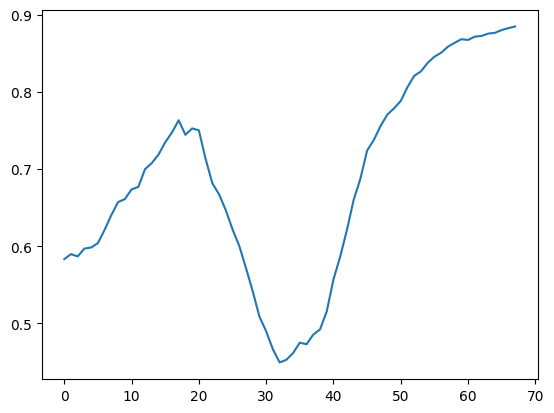

In [29]:
import matplotlib.pyplot as plt
start=2
plt.plot(CSI_scores_out[start*68:(start+1)*68])
plt.show()

In [30]:
np.save("./datas/CSI_in_irregular.npy", np.array(CSI_scores_in))
np.save("./datas/CSI_out_irregular.npy", np.array(CSI_scores_out))

In [31]:
epsilon = 0.05  # Set your threshold
CSI_scores_id_in = []
for idx, (predi, fine) in enumerate(zip(fine_ori, fine_gd)):
    # Extract the 0th dimension (h variable)
    pred_h = predi[mask, 0]
    fine_h = fine[mask, 0]
    # Flatten the arrays and remove NaNs
    pred_flat = pred_h.flatten()
    obs_flat = fine_h.flatten()
    valid_idx = ~np.isnan(pred_flat) & ~np.isnan(obs_flat)
    csi = calculate_csi(pred_flat[valid_idx], obs_flat[valid_idx], epsilon)
    CSI_scores_id_in.append(csi)
    
epsilon = 0.05  # Set your threshold
CSI_scores_id_out = []
for idx, (predi, fine) in enumerate(zip(fine_ori, fine_gd)):
    # Extract the 0th dimension (h variable)
    pred_h = predi[~mask, 0]
    fine_h = fine[~mask, 0]
    # Flatten the arrays and remove NaNs
    pred_flat = pred_h.flatten()
    obs_flat = fine_h.flatten()
    valid_idx = ~np.isnan(pred_flat) & ~np.isnan(obs_flat)
    csi = calculate_csi(pred_flat[valid_idx], obs_flat[valid_idx], epsilon)
    CSI_scores_id_out.append(csi)

In [33]:
np.save("./datas/CSI_in_irregular_id.npy", np.array(CSI_scores_id_in))
np.save("./datas/CSI_out_irregular_id.npy", np.array(CSI_scores_id_out))

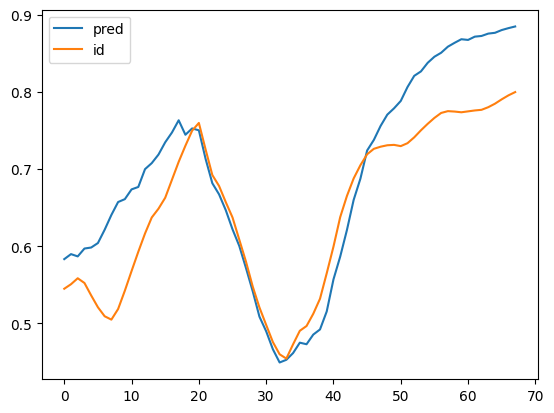

In [37]:
import matplotlib.pyplot as plt
start=2
plt.plot(CSI_scores_out[start*68:(start+1)*68],label='pred')
plt.plot(CSI_scores_id_out[start*68:(start+1)*68],label='id')
plt.legend()
plt.show()